<a href="https://colab.research.google.com/github/Dinuka-1999/EN4553_MV_assignment/blob/Uvin/Vision_Assignment_testing_Uvin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras import layers
from tensorflow import data as tf_data
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pylab as plt

Question a) \\
kNN Classification with the embeddings produced by the ResNet50

In [ ]:
train , test = tfds.load("oxford_iiit_pet",split=["train","test"],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIOQENE/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIOQENE/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
info = tfds.builder("oxford_iiit_pet").info
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

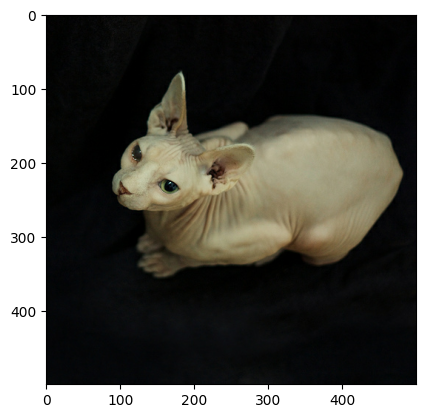

(500, 500, 3)
tf.Tensor(33, shape=(), dtype=int64)


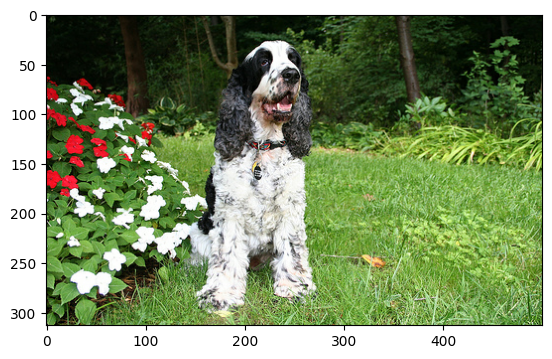

(313, 500, 3)
tf.Tensor(12, shape=(), dtype=int64)


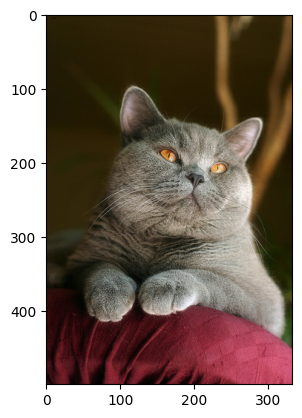

(500, 333, 3)
tf.Tensor(9, shape=(), dtype=int64)


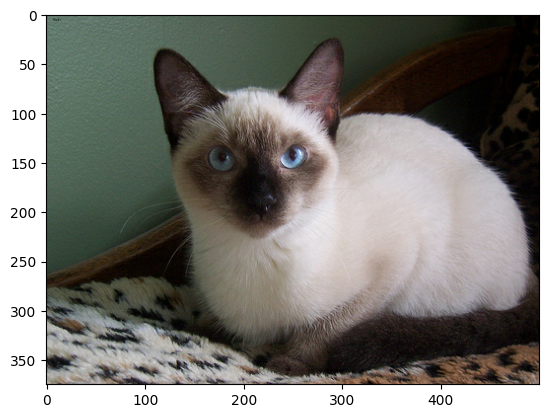

(375, 500, 3)
tf.Tensor(32, shape=(), dtype=int64)


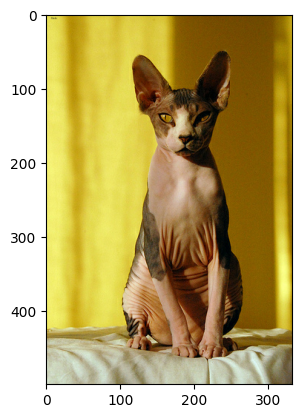

(500, 333, 3)
tf.Tensor(33, shape=(), dtype=int64)


In [ ]:
a=0
for image in train.take(5):
  plt.figure()
  plt.imshow(image[0])
  plt.show()
  print(image[0].shape)
  print(image[1])
  # if a==10:break
  # a+=1


**Editing the Model**

In [ ]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=(224,224,3),pooling="avg")

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Alternative way

In [ ]:
existing_model = tf.keras.applications.ResNet50()

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
new_model = tf.keras.Model(inputs=existing_model.layers[0].input,outputs=existing_model.layers[-2].output)    #top removed

In [ ]:
new_model.summary()

Base model has an input. But the model we are building also need to have an input layer to support our dataset. That input layer is included and pre processing is done so that the data matches to the model

In [ ]:
input = tf.keras.layers.Input(shape=(None,None,3), name="input")    #None is give as the dataset is not pre processed
resized = tf.keras.layers.Resizing(224,224)(input)                  #Model needs 224,224 input
pre_processed = tf.keras.applications.resnet.preprocess_input(resized)

embeddings = base_model(pre_processed)
output = tf.keras.layers.Flatten()(embeddings)
model = tf.keras.Model(inputs=input,outputs=output)

In [ ]:
output.shape          # Classification head is removed

TensorShape([None, 2048])

kNN gets input one by one. Not given Batch wise.

In [ ]:
train_ds = train.map(lambda x,y:(tf.expand_dims(x,axis=0),y))     #Like setting the batch size for 1
train_ds = train_ds.map(lambda x, y:(model(x),y))

test_ds = test.map(lambda x,y:(tf.expand_dims(x,axis=0),y))
test_ds = test_ds.map(lambda x,y:(model(x),y))

kNN can not identify the image and label separately. Therefore need to separate them.

In [ ]:
for x,y in train_ds.take(1):
  print(x)
  print(y)


tf.Tensor([[0.20453066 0.16731362 0.2752168  ... 0.7888254  0.01632865 0.        ]], shape=(1, 2048), dtype=float32)
tf.Tensor(33, shape=(), dtype=int64)


In [ ]:
train_x=[] #Images
train_y=[] #Labels
for x,y in train_ds:
    train_x.append(x[0])   # to remove first squre bracket and give an array of 2048 elements.
    train_y.append(y)

In [ ]:
len(train_y)

3680

In [ ]:
test_x=[]
test_y=[]
for x,y in test_ds:
    test_x.append(x[0])
    test_y.append(y)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifer = KNeighborsClassifier(n_neighbors=10,weights="distance",algorithm="auto")
classifer.fit(train_x,train_y)

KNeighborsClassifier(n_neighbors=10, weights='distance')

In [ ]:
classifer.score(test_x,test_y)

0.8383755791768874

In [ ]:
classifer = KNeighborsClassifier(n_neighbors=5,weights="distance",algorithm="kd_tree")
classifer.fit(train_x,train_y)    #training the classifer
classifer.score(test_x,test_y)

0.8337421640774053

In [ ]:
scores = []
for i in range(5, 201):
  classifier = KNeighborsClassifier(n_neighbors=i, weights="distance", algorithm="auto")
  classifier.fit(train_x, train_y)
  score = classifier.score(test_x, test_y)
  scores.append(score)

In [ ]:
highest_score = max(scores)
k_with_highest_score = scores.index(highest_score) + 5

print(highest_score)
print(k_with_highest_score)



0.84518942491142
47


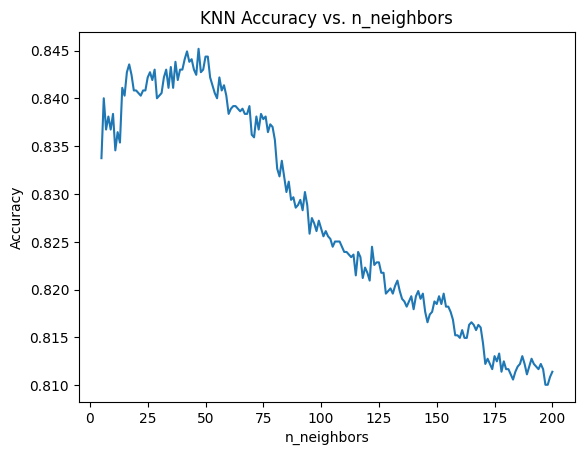

Highest accuracy: 0.8452 at k=47


In [ ]:
plt.plot(range(5, 201), scores)
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs. n_neighbors")
plt.show()

print(f"Highest accuracy: {highest_score:.4f} at k={k_with_highest_score}")

Number of neighbours with highest accuracy is 47

Question b) \\
Linear Classification with pre trained embeddings


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras import layers
from tensorflow import data as tf_data
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
base_model.trainable=False

In [ ]:
model_inputs = keras.Input(shape=(224,224,3))
preprocessed_inputs = tf.keras.applications.resnet.preprocess_input(model_inputs)

base = base_model(pre_processed,training=False)
dense = layers.Dense(512,activation="relu")(base)
drop_out = layers.Dropout(0.4)(dense)
outputs = layers.Dense(37)(drop_out)

model = keras.Model(model_inputs,outputs)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0002,decay=0.00001)

model.compile(optimizer=optimizers,loss=loss_fn,metrics=[keras.metrics.SparseTopKCategoricalAccuracy( k=3, name="accuracy")])

ValueError: ignored